# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
! pip install SimpleITK 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.5 MB/s eta 0:00:00


### Downloading the data

In [2]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip

--2023-03-02 16:45:45--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  14.4MB/s    in 36s     

2023-03-02 16:46:22 (12.5 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating: data

### Setting data directory

In [3]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [4]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

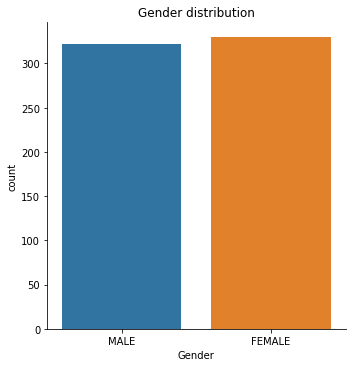

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


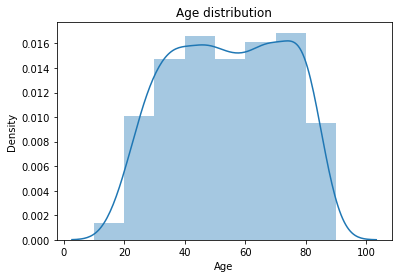

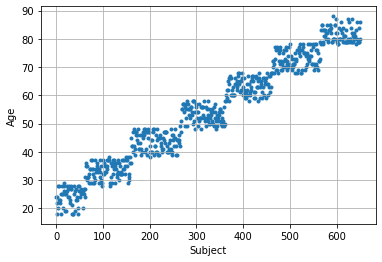

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [6]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

<class 'SimpleITK.SimpleITK.Image'>
Imaging data of subject CC110033 with age 24

MR Image


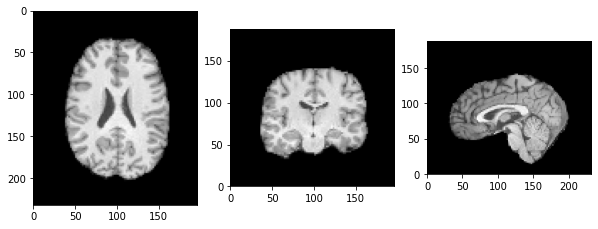

Brain mask


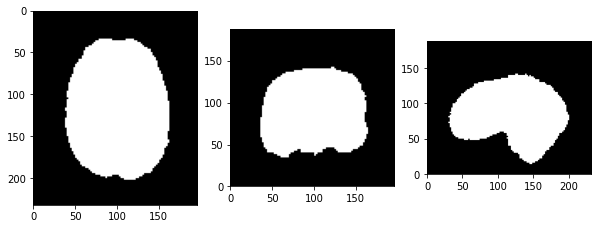

In [7]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)
print(type(img))

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [9]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [10]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [11]:
rnd_seed = 42 #fixed random seed

img_size = [96, 96, 96]
img_spacing = [2, 2, 2]

num_epochs = 150
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [12]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [13]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


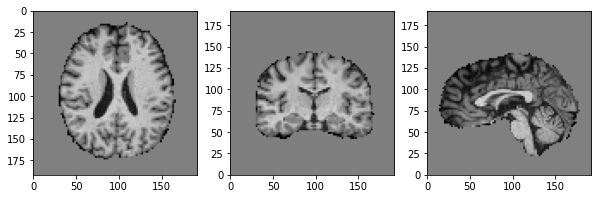

Segmentation


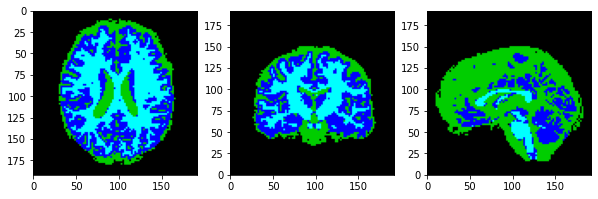

Mask


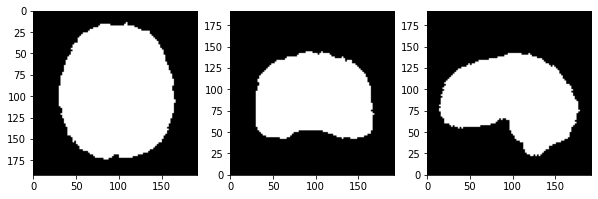

In [14]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [15]:
########################################
# BUILD A BETTER MODEL HERE
########################################

# Inspired from this source: https://amaarora.github.io/2020/09/13/unet.html

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        # Encoder Step
        chs_enc=[1,64,128,256,512,1024]
        self.enc_blocks = nn.ModuleList([Block(chs_enc[i], chs_enc[i+1]) for i in range(len(chs_enc)-1)])
        self.pool = nn.Upsample(scale_factor=0.5)

        # Decoder Step
        chs_dec = [1024,512,256,128,64]
        self.chs_dec=chs_dec
        self.upconvs = nn.ModuleList([nn.ConvTranspose3d(chs_dec[i], chs_dec[i+1], 2, 2) for i in range(len(chs_dec)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs_dec[i], chs_dec[i+1]) for i in range(len(chs_dec)-1)])
        self.head = nn.Conv3d(chs_dec[-1], num_classes, kernel_size=3, padding=1)


        #self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)

    def forward(self, x):
        # Encode Step
        original_size = x.shape
        features = []
        for block in self.enc_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)


        x = features[::-1][0]
        features = features[::-1][1:]
        # Decode Step
        for i in range(len(self.chs_dec)-1):
            x = self.upconvs[i](x)
            x = torch.cat([x, features[i]], dim=1)
            x = self.dec_blocks[i](x)

        x = self.head(x)

        return x # cross-entropy loss expects raw logits and applies softmax

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

In [16]:
# Function to calculate the DSC between individual classes
def calc_dsc_np(pred, ref, num_classes):
    ret_dsc = []
    # Iterate through values and calculate the DSC for each class
    for i in range(num_classes):
        tp = np.sum(np.logical_and(pred == i, ref == i))
        fp = np.sum(np.logical_and(pred == i, ref != i))
        # tn = np.sum(np.logical_and(pred != i, ref != i))
        fn = np.sum(np.logical_and(pred != i, ref == i))
        ret_dsc.append(2 * tp / (2 * tp + fp + fn))

    return ret_dsc

In [17]:
# Connect Google Drive to save and import models and data
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.239293
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.246939


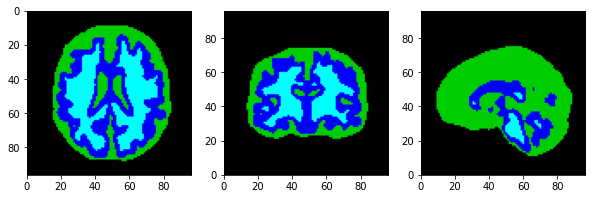

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.332336
+ TRAINING 	Epoch: 3 	Loss: 0.234015
+ TRAINING 	Epoch: 4 	Loss: 0.244717
+ TRAINING 	Epoch: 5 	Loss: 0.195418
+ TRAINING 	Epoch: 6 	Loss: 0.191583
+ TRAINING 	Epoch: 7 	Loss: 0.141268
+ TRAINING 	Epoch: 8 	Loss: 0.175320
+ TRAINING 	Epoch: 9 	Loss: 0.143448
+ TRAINING 	Epoch: 10 	Loss: 0.120153
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.134430


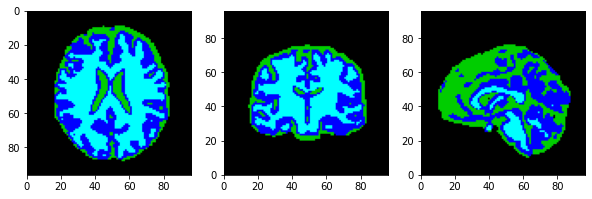

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.175366
+ TRAINING 	Epoch: 12 	Loss: 0.154812
+ TRAINING 	Epoch: 13 	Loss: 0.115075
+ TRAINING 	Epoch: 14 	Loss: 0.116199
+ TRAINING 	Epoch: 15 	Loss: 0.150761
+ TRAINING 	Epoch: 16 	Loss: 0.107675
+ TRAINING 	Epoch: 17 	Loss: 0.101792
+ TRAINING 	Epoch: 18 	Loss: 0.108038
+ TRAINING 	Epoch: 19 	Loss: 0.127769
+ TRAINING 	Epoch: 20 	Loss: 0.093001
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.110715


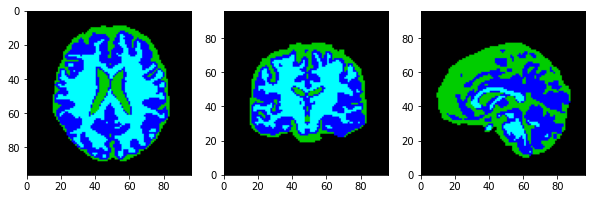

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.105609
+ TRAINING 	Epoch: 22 	Loss: 0.146973
+ TRAINING 	Epoch: 23 	Loss: 0.129945
+ TRAINING 	Epoch: 24 	Loss: 0.090712
+ TRAINING 	Epoch: 25 	Loss: 0.107855
+ TRAINING 	Epoch: 26 	Loss: 0.125289
+ TRAINING 	Epoch: 27 	Loss: 0.118504
+ TRAINING 	Epoch: 28 	Loss: 0.084741
+ TRAINING 	Epoch: 29 	Loss: 0.087994
+ TRAINING 	Epoch: 30 	Loss: 0.100795
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.118676


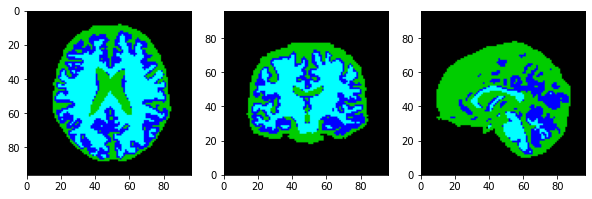

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.095790
+ TRAINING 	Epoch: 32 	Loss: 0.098046
+ TRAINING 	Epoch: 33 	Loss: 0.133170
+ TRAINING 	Epoch: 34 	Loss: 0.105151
+ TRAINING 	Epoch: 35 	Loss: 0.097913
+ TRAINING 	Epoch: 36 	Loss: 0.130017
+ TRAINING 	Epoch: 37 	Loss: 0.099602
+ TRAINING 	Epoch: 38 	Loss: 0.098913
+ TRAINING 	Epoch: 39 	Loss: 0.124282
+ TRAINING 	Epoch: 40 	Loss: 0.112369
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.090438


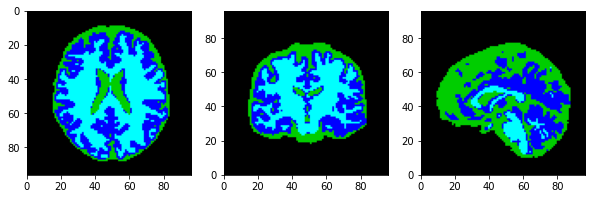

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.092359
+ TRAINING 	Epoch: 42 	Loss: 0.076419
+ TRAINING 	Epoch: 43 	Loss: 0.073967
+ TRAINING 	Epoch: 44 	Loss: 0.082714
+ TRAINING 	Epoch: 45 	Loss: 0.099137
+ TRAINING 	Epoch: 46 	Loss: 0.092480
+ TRAINING 	Epoch: 47 	Loss: 0.103620
+ TRAINING 	Epoch: 48 	Loss: 0.086670
+ TRAINING 	Epoch: 49 	Loss: 0.084079
+ TRAINING 	Epoch: 50 	Loss: 0.071825
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.084805


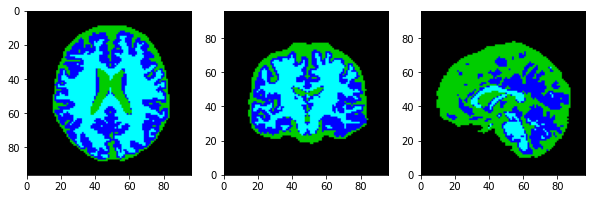

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.095087
+ TRAINING 	Epoch: 52 	Loss: 0.077897
+ TRAINING 	Epoch: 53 	Loss: 0.090186
+ TRAINING 	Epoch: 54 	Loss: 0.087344
+ TRAINING 	Epoch: 55 	Loss: 0.092104
+ TRAINING 	Epoch: 56 	Loss: 0.097846
+ TRAINING 	Epoch: 57 	Loss: 0.079998
+ TRAINING 	Epoch: 58 	Loss: 0.087354
+ TRAINING 	Epoch: 59 	Loss: 0.099623
+ TRAINING 	Epoch: 60 	Loss: 0.072694
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.084267


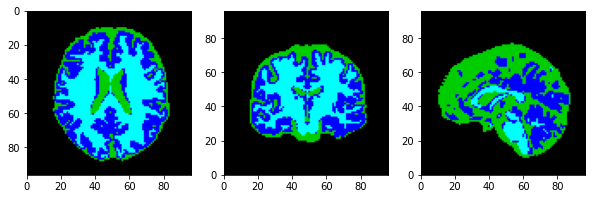

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.081656
+ TRAINING 	Epoch: 62 	Loss: 0.102754
+ TRAINING 	Epoch: 63 	Loss: 0.087057
+ TRAINING 	Epoch: 64 	Loss: 0.125446
+ TRAINING 	Epoch: 65 	Loss: 0.085323
+ TRAINING 	Epoch: 66 	Loss: 0.157112
+ TRAINING 	Epoch: 67 	Loss: 0.077346
+ TRAINING 	Epoch: 68 	Loss: 0.083429
+ TRAINING 	Epoch: 69 	Loss: 0.082774
+ TRAINING 	Epoch: 70 	Loss: 0.095951
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.089458


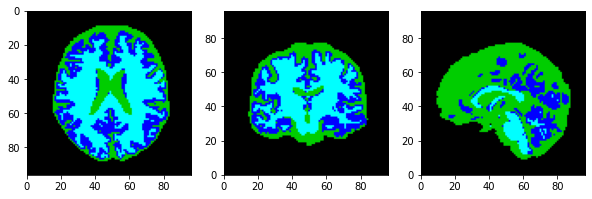

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.100934
+ TRAINING 	Epoch: 72 	Loss: 0.085400
+ TRAINING 	Epoch: 73 	Loss: 0.083269
+ TRAINING 	Epoch: 74 	Loss: 0.103822
+ TRAINING 	Epoch: 75 	Loss: 0.090129
+ TRAINING 	Epoch: 76 	Loss: 0.102997
+ TRAINING 	Epoch: 77 	Loss: 0.064917
+ TRAINING 	Epoch: 78 	Loss: 0.081841
+ TRAINING 	Epoch: 79 	Loss: 0.169672
+ TRAINING 	Epoch: 80 	Loss: 0.070251
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.078368


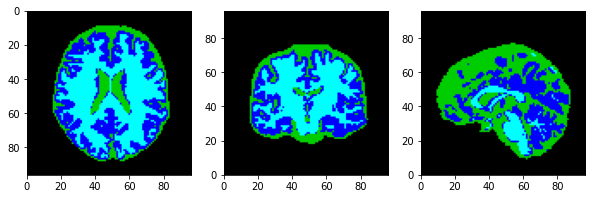

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.093361
+ TRAINING 	Epoch: 82 	Loss: 0.064081
+ TRAINING 	Epoch: 83 	Loss: 0.094830
+ TRAINING 	Epoch: 84 	Loss: 0.070361
+ TRAINING 	Epoch: 85 	Loss: 0.058753
+ TRAINING 	Epoch: 86 	Loss: 0.089529
+ TRAINING 	Epoch: 87 	Loss: 0.100808
+ TRAINING 	Epoch: 88 	Loss: 0.102902
+ TRAINING 	Epoch: 89 	Loss: 0.089595
+ TRAINING 	Epoch: 90 	Loss: 0.092604
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.076260


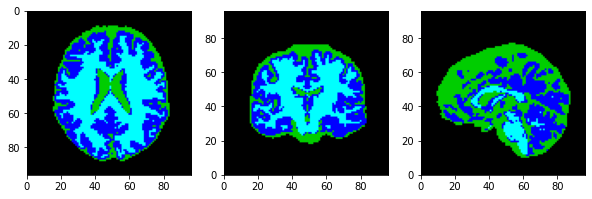

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.073214
+ TRAINING 	Epoch: 92 	Loss: 0.145802
+ TRAINING 	Epoch: 93 	Loss: 0.087098
+ TRAINING 	Epoch: 94 	Loss: 0.096377
+ TRAINING 	Epoch: 95 	Loss: 0.064194
+ TRAINING 	Epoch: 96 	Loss: 0.066612
+ TRAINING 	Epoch: 97 	Loss: 0.069273
+ TRAINING 	Epoch: 98 	Loss: 0.064893
+ TRAINING 	Epoch: 99 	Loss: 0.068480
+ TRAINING 	Epoch: 100 	Loss: 0.079321
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.075976


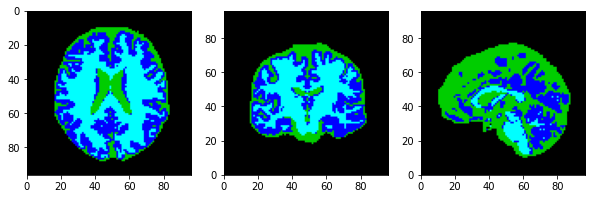

--------------------------------------------------
+ TRAINING 	Epoch: 101 	Loss: 0.059618
+ TRAINING 	Epoch: 102 	Loss: 0.062225
+ TRAINING 	Epoch: 103 	Loss: 0.153338
+ TRAINING 	Epoch: 104 	Loss: 0.078711
+ TRAINING 	Epoch: 105 	Loss: 0.088321
+ TRAINING 	Epoch: 106 	Loss: 0.062287
+ TRAINING 	Epoch: 107 	Loss: 0.075991
+ TRAINING 	Epoch: 108 	Loss: 0.051334
+ TRAINING 	Epoch: 109 	Loss: 0.058911
+ TRAINING 	Epoch: 110 	Loss: 0.074026
--------------------------------------------------
+ VALIDATE 	Epoch: 110 	Loss: 0.068630


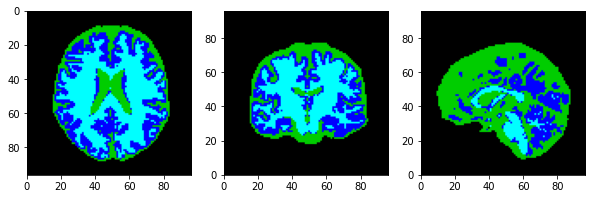

--------------------------------------------------
+ TRAINING 	Epoch: 111 	Loss: 0.080203
+ TRAINING 	Epoch: 112 	Loss: 0.093503
+ TRAINING 	Epoch: 113 	Loss: 0.073246
+ TRAINING 	Epoch: 114 	Loss: 0.056822
+ TRAINING 	Epoch: 115 	Loss: 0.165259
+ TRAINING 	Epoch: 116 	Loss: 0.054365
+ TRAINING 	Epoch: 117 	Loss: 0.056811
+ TRAINING 	Epoch: 118 	Loss: 0.062651
+ TRAINING 	Epoch: 119 	Loss: 0.071356
+ TRAINING 	Epoch: 120 	Loss: 0.091208
--------------------------------------------------
+ VALIDATE 	Epoch: 120 	Loss: 0.067678


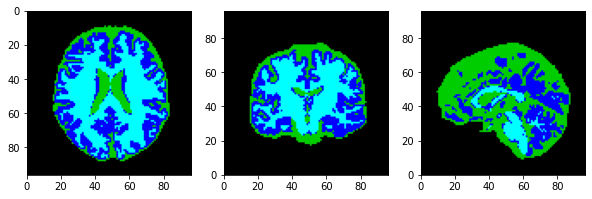

--------------------------------------------------
+ TRAINING 	Epoch: 121 	Loss: 0.080523
+ TRAINING 	Epoch: 122 	Loss: 0.065091
+ TRAINING 	Epoch: 123 	Loss: 0.067434
+ TRAINING 	Epoch: 124 	Loss: 0.081602
+ TRAINING 	Epoch: 125 	Loss: 0.079339
+ TRAINING 	Epoch: 126 	Loss: 0.072995
+ TRAINING 	Epoch: 127 	Loss: 0.058537
+ TRAINING 	Epoch: 128 	Loss: 0.093693
+ TRAINING 	Epoch: 129 	Loss: 0.069449
+ TRAINING 	Epoch: 130 	Loss: 0.058395
--------------------------------------------------
+ VALIDATE 	Epoch: 130 	Loss: 0.073878


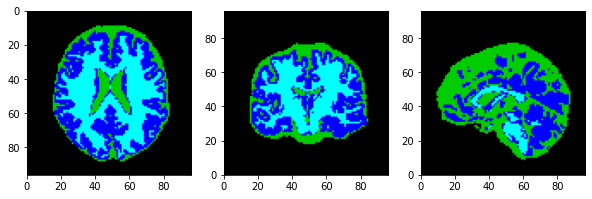

--------------------------------------------------
+ TRAINING 	Epoch: 131 	Loss: 0.058141
+ TRAINING 	Epoch: 132 	Loss: 0.118956
+ TRAINING 	Epoch: 133 	Loss: 0.058715
+ TRAINING 	Epoch: 134 	Loss: 0.069099
+ TRAINING 	Epoch: 135 	Loss: 0.069254
+ TRAINING 	Epoch: 136 	Loss: 0.071946
+ TRAINING 	Epoch: 137 	Loss: 0.056376
+ TRAINING 	Epoch: 138 	Loss: 0.066130
+ TRAINING 	Epoch: 139 	Loss: 0.058386
+ TRAINING 	Epoch: 140 	Loss: 0.057816
--------------------------------------------------
+ VALIDATE 	Epoch: 140 	Loss: 0.068558


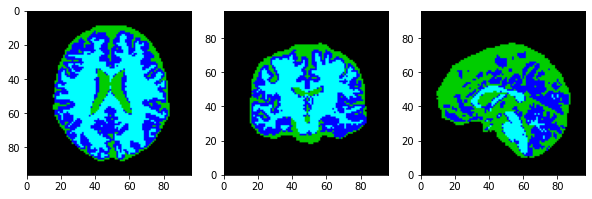

--------------------------------------------------
+ TRAINING 	Epoch: 141 	Loss: 0.066761
+ TRAINING 	Epoch: 142 	Loss: 0.087686
+ TRAINING 	Epoch: 143 	Loss: 0.062692
+ TRAINING 	Epoch: 144 	Loss: 0.055687
+ TRAINING 	Epoch: 145 	Loss: 0.068859
+ TRAINING 	Epoch: 146 	Loss: 0.070889
+ TRAINING 	Epoch: 147 	Loss: 0.054747
+ TRAINING 	Epoch: 148 	Loss: 0.062696
+ TRAINING 	Epoch: 149 	Loss: 0.056481
+ TRAINING 	Epoch: 150 	Loss: 0.063554
--------------------------------------------------
+ VALIDATE 	Epoch: 150 	Loss: 0.065689


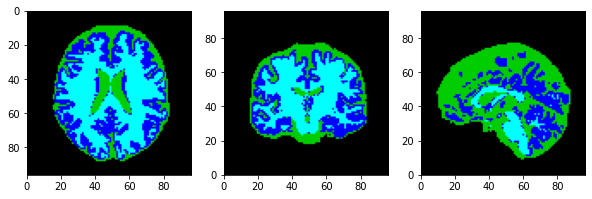

--------------------------------------------------

Finished TRAINING.


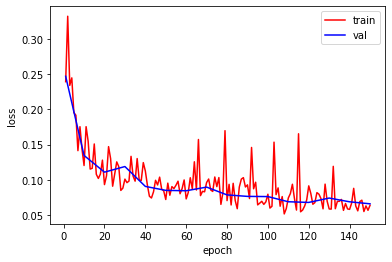

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

# Apply the simple architecture which results in 4 output feature maps
model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []

dsc_train_log = []
dsc_val_log = []

epoch_val_log = []

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        # img.shape and seg.shape : 2 x 1 x 64 x 64 x 64
        optimizer.zero_grad()
        prd = model(img) # prd.shape : 2 x 4 x 64 x 64 x 64
        # The 2 comes from the model batch size accessed through batch_size

        # Iterate through the number of batches in this set to calculate DSC
        for i in range(prd.shape[0]):
            # Calculate DSC per batch
            prd_array = torch.argmax(prd, dim=1) # 2, 64, 64, 64
            prd_array = prd_array[i,:,:,:]
            prd_array = prd_array.cpu().numpy()
            dsc = calc_dsc_np(prd_array, seg.cpu().numpy(), num_classes)
            dsc_train_log.append(dsc)

        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)

                # Calculate DSC
                prd_array = torch.argmax(prd, dim=1) # 1, 64, 64, 64
                prd_array = prd_array.squeeze(0) # Tensor : 64, 64, 64 
                prd_array = prd_array.cpu().numpy()

                dsc_val_log.append(calc_dsc_np(prd_array, seg.cpu().numpy(), num_classes))
                
        prd = torch.argmax(prd, dim=1) # 1, 64, 64, 64
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# -------- Back up data and models in Google Drive to avoid having to retrain --------
# import json
# with open('dsc_train_log.json', 'w') as f:
#     json.dump(dsc_train_log, f)

# with open('dsc_val_log.json', 'w') as f:
#     json.dump(dsc_val_log, f)

# !cp dsc_train_log.json drive/MyDrive/Imperial/Retrain/dsc_train_log.json
# !cp dsc_val_log.json drive/MyDrive/Imperial/Retrain/dsc_val_log.json

# !cp output/model/model.pt drive/MyDrive/Imperial/Retrain/model.pt

In [ ]:
# -------- Import data back in from Google Drive --------
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# !cp drive/MyDrive/Imperial/Retrain/dsc_train_log.json dsc_train_log.json
# !cp drive/MyDrive/Imperial/Retrain/dsc_val_log.json dsc_val_log.json

# import json
# dsc_train_log = []
# with open("dsc_train_log.json") as f:
#     dsc_train_log = json.load(f)

# dsc_val_log = []
# with open("dsc_val_log.json") as f:
#     dsc_val_log = json.load(f)

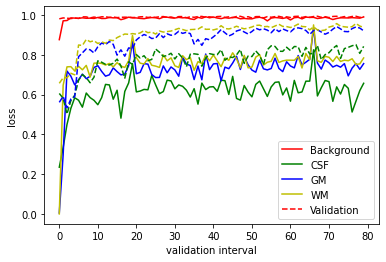

In [ ]:
import numpy as np
dsc_val_log = np.array(dsc_val_log)
dsc_train_log = np.array(dsc_train_log)

# Plot the DSC changes - training values need to be adjusted per epoch
plt.plot(dsc_train_log[:,0][0:7050:89], c='r', label='Background')
plt.plot(dsc_train_log[:,1][0:7050:89], c='g', label='CSF')
plt.plot(dsc_train_log[:,2][0:7050:89], c='b', label='GM')
plt.plot(dsc_train_log[:,3][0:7050:89], c='y', label='WM')

plt.plot(dsc_val_log[:,0], '--', c='r', label='Validation')
plt.plot(dsc_val_log[:,1], '--', c='g')
plt.plot(dsc_val_log[:,2], '--', c='b')
plt.plot(dsc_val_log[:,3], '--', c='y')

plt.legend(loc='lower right')
plt.xlabel('validation interval')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [20]:
# Load in regression training data to produce segmentation maps from
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [03:37<00:00,  2.30it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


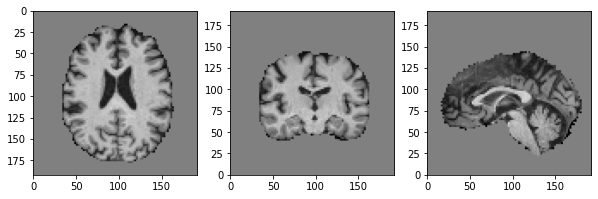

Segmentation


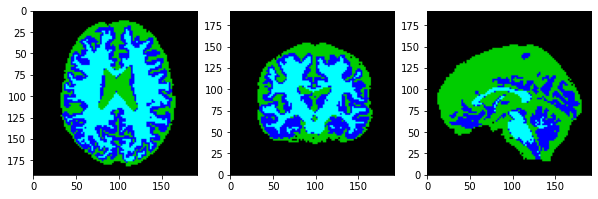

Mask


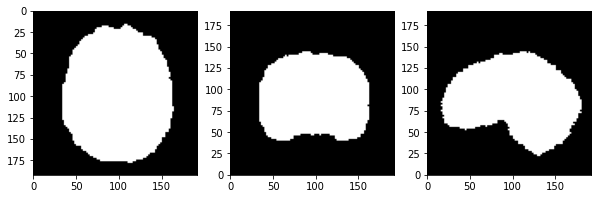

In [21]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

In [18]:
# ------- Bring in model from Google Drive if needed -------
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!cp drive/MyDrive/Imperial/Retrain/model.pt output/model/model.pt

Mounted at /content/drive/


START TESTING...
+ TESTING 	Loss: 0.080078


Reference segmentation


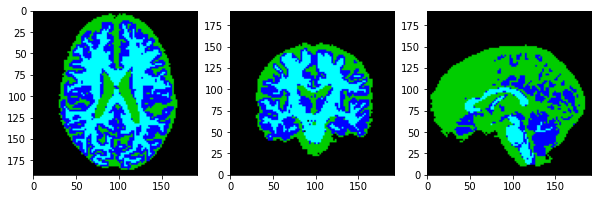

Predicted segmentation


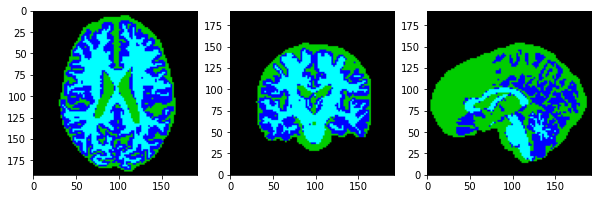


Finished TESTING.


In [22]:
# Creating prediction segmentation maps from the test images
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0

dcs_log = np.empty((0,num_classes))

with torch.no_grad():
    for data_sample in dataloader_test: # temporarily changing from dataloader_test to dataloader_val
        # so dataset_test changes to dataset_val
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img) # Output prediction, type: Tensor : 1, 4, 64, 64, 64
        # 4 - indicates the 4 probabilities of each voxel being associated with that class
        # print(prd[:,:,32,32,32])
        # 1st index value seems to be saying what class that voxel is
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)

        # Returns indices of the maximum values of all elements in the input tensor at dimension 1
        # By taking the maximum value, it is assigning each voxel a class based on the highest
        #   probability within the array of 4 values
        prd = torch.argmax(prd, dim=1) # 1, 64, 64, 64
        # Squeeze the 0th axis so that it is in the same format as the segmentation reference
        prd_array = prd.squeeze(0) # Tensor : 64, 64, 64 
        # Convert to numpy array
        prd_array = prd_array.cpu().numpy()
        # Can now access all segmentation points belonging to each class by accessing index 0

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        # sample['seg'] can be used to access the associated segmentation reference
        #   where each value in each index is the class associated with that voxel
        # sample['seg'] : Image : 64, 64, 64

        # Convert the image to a numpy array
        seg_array = sitk.GetArrayFromImage(sample['seg'])

        # Store log of DCS values per data point
        dcs_log = np.vstack([dcs_log, calc_dsc_np(prd_array, seg_array, 4)])

        # Converting the prediction to a SimpleITK image - used to then display
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.int64))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
                
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb209f8c220>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb209f8c7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb20951ed90>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb209f8cd60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb209f8f070>,
 'means': []}

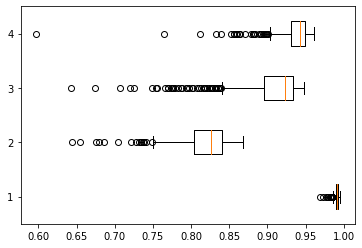

In [23]:
# Draw box and whisker plot for output values
plt.boxplot(dcs_log, vert=False)

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

Calculating Features: 100%|██████████| 500/500 [00:05<00:00, 94.01it/s]


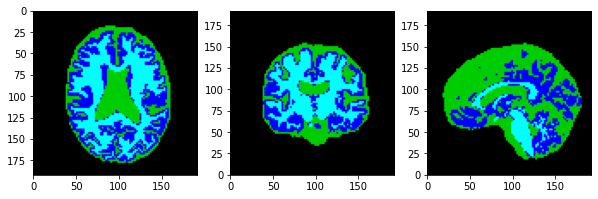

Number of CSF voxels:  56685.0
Number of GM voxels:  65601.0
Number of WM voxels:  47977.0


In [24]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
# seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
# Get segmentation maps
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train))) # 3, 500

# Iterate through the segmentation maps
for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename) # 98 x 116 x 94
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################

        # Convert to numpy array
        seg = sitk.GetArrayFromImage(seg)
        
        # Calculate volume of pixels per class
        class1 = np.sum(seg == 1) # CSF
        class2 = np.sum(seg == 2) # GM
        class3 = np.sum(seg == 3) # WM

        vols[:,idx] = [class1, class2, class3]

# Visualise one of the segmentation examples
seg = sitk.ReadImage(files_reg_seg_train[2])
display_image(sitk.LabelToRGB(seg))
print("Number of CSF voxels: ", vols[0,2])
print("Number of GM voxels: ", vols[1,2])
print("Number of WM voxels: ", vols[2,2])

Plot features versus age.

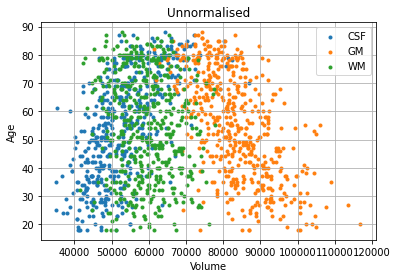

In [25]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [26]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################
vols_normalised = vols / vols.sum(axis=0)

# Print to compare values
print(vols)
print(vols_normalised)

[[56605. 46855. 56685. ... 53662. 50724. 61729.]
 [73669. 73421. 65601. ... 81750. 91507. 87235.]
 [56429. 47477. 47977. ... 57076. 59437. 63155.]]
[[0.30318206 0.27930946 0.33292612 ... 0.27878101 0.2515223  0.29101118]
 [0.39457856 0.43767325 0.38529217 ... 0.4247018  0.45375072 0.411255  ]
 [0.30223939 0.28301729 0.28178171 ... 0.29651719 0.29472698 0.29773382]]


Plot normalised features versus age.

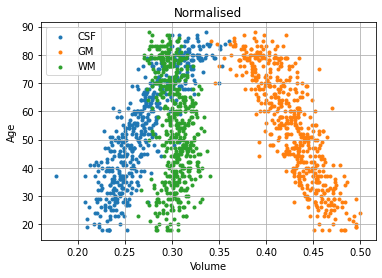

In [27]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [28]:
# Take inputs normalised volumes and convert them into a new feature vector
def convert_features(norm_X, len_data):
    n = 2 # number of dimensions in the feature map
    ret_X = np.zeros((n,len_data)) # 6 x 100 or 6 x 500
    # row 0 - CSF
    # row 1 - GM
    # row 2 - WM

    ret_X[0,:] = norm_X[0,:]
    ret_X[1,:] = norm_X[1,:]

    # ret_X[2,:] = norm_X[0,:]**2
    # ret_X[3,:] = norm_X[1,:]**2
    # ret_X[4,:] = norm_X[0,:]**2 + norm_X[0,:]*norm_X[1,:] + norm_X[1,:]**2

    # Standardize along features
    for i in range(n):
        ret_X[i,:] = (ret_X[i,:] - np.mean(ret_X[i,:])) / np.std(ret_X[i,:])

    return ret_X # shape : n x number of training samples

In [29]:
# Prepare data to be passed into the regression models
vols_fm = convert_features(vols_normalised, len(files_reg_seg_train))
X_train = vols_fm.T
y_train = meta_data_reg_train['age'].values.reshape(-1,1)

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [30]:
# Regression models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [31]:
########################################
# ADD YOUR CODE HERE
########################################

# Split X and y into two folds
X_fold1, X_fold2, y_fold1, y_fold2 = train_test_split(X_train, y_train, test_size = 0.5)
print(X_fold1.shape)
print(y_fold1.shape)

(250, 2)
(250, 1)


# Regression models

In [32]:
# General functions

# Take an input regression model, perform cross-validation training and
#   evaluate against the ground truth labels
def apply_regression(model, X1, X2, y1, y2):
    reg = model.fit(X1, y1) # Train on the first fold
    fold2_preds = reg.predict(X2) # Get predictions from the second fold

    reg = model.fit(X2, y2) # Train on the second fold 
    fold1_preds = reg.predict(X1) # Get prediction from the first fold

    predicted = np.concatenate((fold1_preds, fold2_preds), axis=0)
    y = np.concatenate((y1, y2), axis=0)

    return predicted, y

# Given code to print the prediction metrics and make a graph
#   showing the real vs predicted age
def error_calc_and_plot(predicted, y):
    mae = mean_absolute_error(y,predicted)
    r2 = r2_score(y,predicted)
    print('MAE: {0}'.format(mae))
    print('R2: {0}'.format(r2))

    fig, ax = plt.subplots()
    ax.scatter(y, predicted, marker='.')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    ax.set_xlabel('Real Age')
    ax.set_ylabel('Predicted Age')
    plt.show()

    return mean_absolute_error(y,predicted), r2

###### Simple Linear regression

MAE: 7.481139952747882
R2: 0.7460788303553991


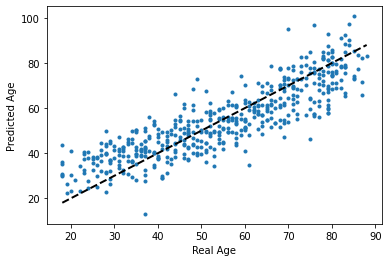

In [33]:
# Simple Linear regression
predicted_lr, y_lr = apply_regression(LinearRegression(), X_fold1, X_fold2, y_fold1, y_fold2)
mae_lr, r2_lr = error_calc_and_plot(predicted_lr, y_lr)

MAE: 8.18633723784873
R2: 0.7040209130944933


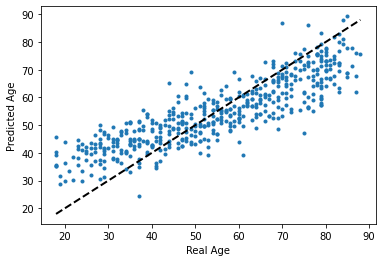

In [34]:
# Simple Linear regression with regularization (Elastic Net)
predicted_lr, y_lr = apply_regression(ElasticNet(), X_fold1, X_fold2, y_fold1, y_fold2)
mae_lre, r2_lre = error_calc_and_plot(predicted_lr, y_lr)

###### Regression trees

MAE: 8.978853246753246
R2: 0.5866562795388494


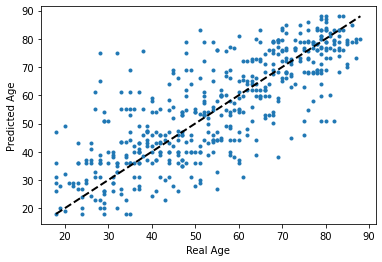

In [35]:
predicted_tree, y_tree = apply_regression(DecisionTreeRegressor(max_depth=10), X_fold1, X_fold2, y_fold1, y_fold2)
mae_tree, r2_tree = error_calc_and_plot(predicted_tree, y_tree)

###### Neural Networks

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MAE: 6.857555698772921
R2: 0.774263356630053


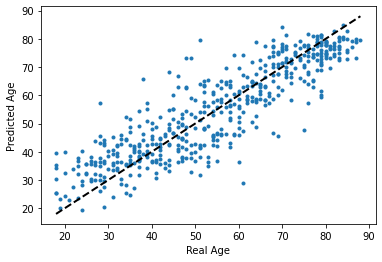

In [36]:
predicted_mlp, y_mlp = apply_regression(MLPRegressor(hidden_layer_sizes=(64,32,16), solver='lbfgs', max_iter=75),
                                        X_fold1, X_fold2, y_fold1.squeeze(), y_fold2.squeeze())

mae_nn, r2_nn = error_calc_and_plot(predicted_mlp, y_mlp)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MAE: 6.9431181224396985
R2: 0.7655574916173773


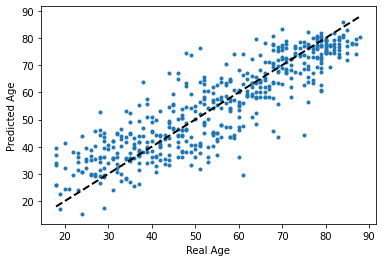

In [37]:
# Increased regularization term to 2e-4
predicted_mlp, y_mlp = apply_regression(MLPRegressor(hidden_layer_sizes=(64,32,16), solver='lbfgs', max_iter=75, alpha=0.0002),
                                        X_fold1, X_fold2, y_fold1.squeeze(), y_fold2.squeeze())

mae_nn_reg, r2_nn_reg = error_calc_and_plot(predicted_mlp, y_mlp)

###### SVMs - Support Vector Regression

MAE: 7.681956370803909
R2: 0.7334888150108505


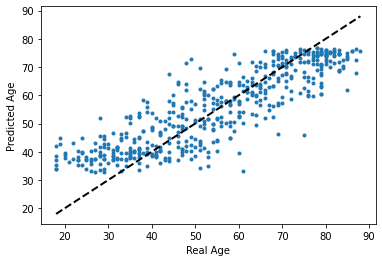

In [38]:
predicted_svr, y_svr = apply_regression(SVR(), X_fold1, X_fold2, y_fold1.squeeze(), y_fold2.squeeze())
mae_svr, r2_svr = error_calc_and_plot(predicted_svr, y_svr)

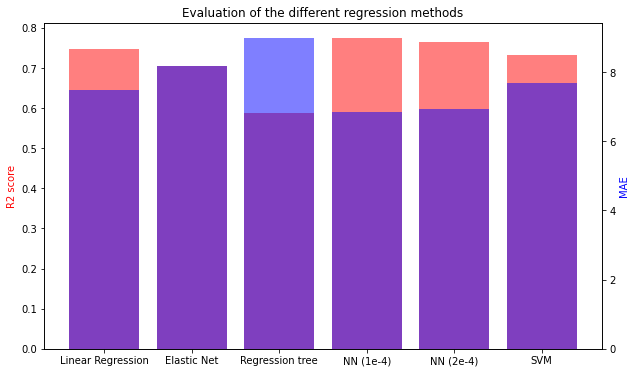

In [39]:
# Plot a bar chart to compare the MAE and R2 scores of the regression methods
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
mae_data = [mae_lr, mae_lre, mae_tree, mae_nn, mae_nn_reg, mae_svr]
r2_data = [r2_lr, r2_lre, r2_tree, r2_nn, r2_nn_reg, r2_svr]

ax1.bar(np.arange(len(r2_data)), r2_data, color='red', alpha=0.5)
ax2 = ax1.twinx()
ax2.bar(np.arange(len(mae_data)), mae_data, color='blue', alpha=0.5)

ax1.set_ylabel('R2 score', color='red')
ax2.set_ylabel('MAE', color='blue')
plt.title('Evaluation of the different regression methods')
ax1.set_xticks(np.arange(len(r2_data)))
ax1.set_xticklabels(['Linear Regression', 'Elastic Net', 'Regression tree', 'NN (1e-4)', 'NN (2e-4)', 'SVM'])

plt.show()

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [40]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-03-02 16:56:51--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-03-02 16:56:52 (318 MB/s) - ‘brainage-test-data.zip’ saved [1521/1521]

Archive:  brainage-test-data.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [41]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


#### Run final testing

In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

GENERATING SEGMENTATION MAPS
+ TESTING 	Loss: 0.075424


Reference segmentation


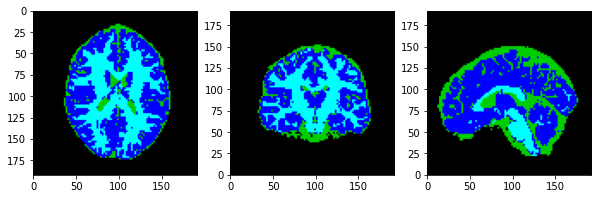

Predicted segmentation


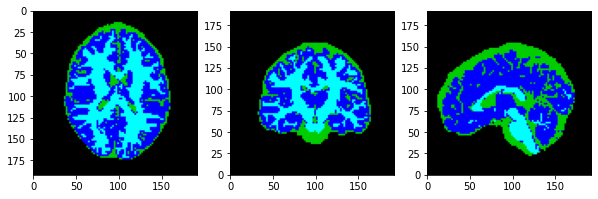


Finished TESTING.


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb209598190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb209598610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb2085eee80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb209598bb0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb209598e80>,
 'means': []}

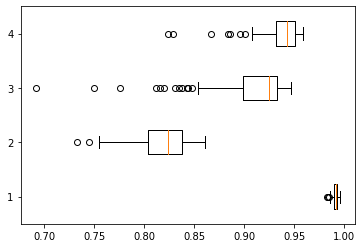

In [42]:
# Generate segmentation maps of the test images using our model
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('GENERATING SEGMENTATION MAPS')

loss_test = 0
sum_pts = 0
idx_test = 0

dcs_log = np.empty((0,num_classes))

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img) # Output prediction, type: Tensor : 1, 4, 64, 64, 64
        # 4 - indicates the 4 probabilities of each voxel being associated with that class
        # print(prd[:,:,32,32,32])
        # 1st index value seems to be saying what class that voxel is
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)

        # Returns indices of the maximum values of all elements in the input tensor at dimension 1
        # By taking the maximum value, it is assigning each voxel a class based on the highest
        #   probability within the array of 4 values
        prd = torch.argmax(prd, dim=1) # 1, 64, 64, 64
        # Squeeze the 0th axis so that it is in the same format as the segmentation reference
        prd_array = prd.squeeze(0) # Tensor : 64, 64, 64 
        # Convert to numpy array
        prd_array = prd_array.cpu().numpy()
        # Can now access all segmentation points belonging to each class by accessing index 0

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        # sample['seg'] can be used to access the associated segmentation reference
        #   where each value in each index is the class associated with that voxel
        # sample['seg'] : Image : 64, 64, 64

        # Convert the image to a numpy array
        seg_array = sitk.GetArrayFromImage(sample['seg'])

        # Store log of DCS values per data point
        dcs_log = np.vstack([dcs_log, calc_dsc_np(prd_array, seg_array, 4)])

        # Converting the prediction to a SimpleITK image - used to then display
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.int64))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
                
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

# Draw box and whisker plot for output values
plt.boxplot(dcs_log, vert=False)

Calculating Features: 100%|██████████| 100/100 [00:02<00:00, 38.37it/s]


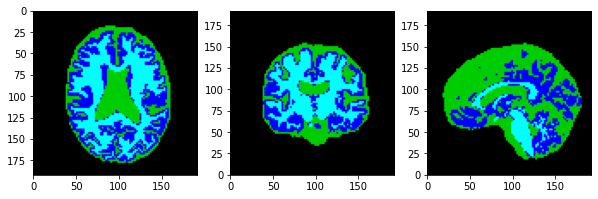

In [43]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
files_seg_seg_test = ['./output/pred/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]

# USE THIS TO RUN THE CALCULATIONS THE PROVIDED TEST REFERENCE SEGMENTATIONS
# files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols_test = np.zeros((3,len(files_seg_seg_test))) # 3, 500

# Iterate through the segmentation maps
for idx, _ in enumerate(tqdm(range(len(files_seg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_seg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        # Convert to numpy array
        seg = sitk.GetArrayFromImage(seg)
        
        # Calculate volume of pixels per class
        class1 = np.sum(seg == 1) # CSF
        class2 = np.sum(seg == 2) # GM
        class3 = np.sum(seg == 3) # WM

        vols_test[:,idx] = [class1, class2, class3]
# Visualise one of the segmentation examples
seg = sitk.ReadImage(files_reg_seg_train[2])
display_image(sitk.LabelToRGB(seg))

In [44]:
# Normalise vols_test then convert them to the new feature map
vols_test_norm = vols_test / vols_test.sum(axis=0)
vols_test_fm = convert_features(vols_test_norm, len(files_seg_seg_test))
X_test = vols_test_fm.T

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MAE: 6.725580759922757
R2: 0.8200094923706


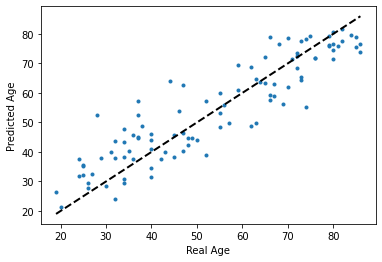

(6.725580759922757, 0.8200094923706)

In [46]:
# Test the best model (from part A3) on the entire training set of 500 images
model = MLPRegressor(hidden_layer_sizes=(64,32,16), solver='lbfgs', max_iter=75, alpha=0.0002)
# Train using the training data
model.fit(X_train, y_train)
# Test on the volumes output from the test data
test_predictions = model.predict(X_test)
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

error_calc_and_plot(test_predictions, y_test)

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [ ]:
########################################
# TASK COMPLETED IN THE OTHER NOTEBOOK
########################################